In [22]:
# load_qdrant.py
# Usage:
#   pip install -U langchain-qdrant qdrant-client langchain-mistralai python-dotenv
#   export MISTRAL_API_KEY=...
#   python load_qdrant.py <qdrant_dir> <collection_name> ["your query"] [k]
#
# Example:
#   python load_qdrant.py stores/qdrant_db rg_chunks "Benefits from 'Extract Method'" 5

import sys
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from langchain_mistralai import MistralAIEmbeddings
from langchain_qdrant import QdrantVectorStore
import os

load_dotenv()
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")



# qdrant_dir = sys.argv[1]
collection_name = "test"


# Open local (embedded) Qdrant DB folder
client = QdrantClient(
        url=QDRANT_URL, 
        api_key=QDRANT_API_KEY,
    )

# Same embedding model used when building the collection
embeddings = MistralAIEmbeddings(model="mistral-embed")

# Create a LangChain vector store bound to the existing collection
store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)




d:\NASA\NASA_Nexus\.venv\Lib\site-packages\pydantic\main.py:253: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [ ]:
import bs4
from langchain import hub
# from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain.chat_models import init_chat_model

prompt = hub.pull("rlm/rag-prompt")
llm = init_chat_model("open-mixtral-8x7b", model_provider="mistralai")

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    #=================================
    assert len(messages.to_messages()) == 1
    print(messages.to_messages()[0].content)
    #=================================
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

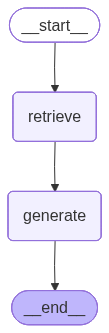

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
response = graph.invoke({"question": "What advantages does the BioFlux-based method offer for studying biofilms compared to traditional static microtiter plate methods?"})
print(response["answer"])

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What advantages does the BioFlux-based method offer for studying biofilms compared to traditional static microtiter plate methods? 
Context: The plate reader-based BioFlux viability screening method relied on the use of bacterial strains expressing GFP; for non-GFP-expressing bacteria another method, such as LIVE/DEAD *Bac*Light staining, must be used. However, the *Bac*Light viability method, as reported previously for planktonic cells ([3](#r3), [24](#r24)) and confirmed here for biofilms, is limited to treatments causing a relatively higher level of killing. This finding appears to limit use of the BioFlux to bacteria capable of expressing GFP. However, there are other possibilities. For example, the LIVE/DEAD stain is accurate for determi